# Code for generating SFig9 panels from derivative data

#### Raw code for generating derivative data is in analysis1_compute_regional_RDMs.py (using default parameters for main text figures)

`python analysis1_compute_regional_RDMs.py`

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [17]:
figuredir = '../figures/SFig9/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']
    
# Set task ordering
unique_tasks = ['NoGo','Go','TheoryOfMind','VideoActions','VideoKnots','Math',
                'DigitJudgement','Objects','MotorImagery','FingerSimple','FingerSeq',
                'Verbal2Back','SpatialImagery','VerbGen','WordRead','Rest',
                'PermutedRules','SpatialMapEasy','SpatialMapMed','SpatialMapHard',
                'NatureMovie','AnimatedMovie','LandscapeMovie','UnpleasantScenes','PleasantScenes',
                'SadFaces','HappyFaces','Object2Back','IntervalTiming',
                'Prediction','PredictViol','PredictScram','VisualSearchEasy','VisualSearchMed','VisualSearchHard',
                'StroopIncon','StroopCon','MentalRotEasy','MentalRotMed','MentalRotHard',
                'BiologicalMotion','ScrambledMotion','RespAltEasy','RespAltMed','RespAltHard']

task_passivity = ['left','left','left','passive','passive','right',
                  'right','passive','passive','both','both',
                  'left','passive','passive','passive','passive',
                  'both','both','both','both',
                  'passive','passive','passive','left','left',
                  'right','right','right','right',
                  'left','left','left','left','left','left',
                  'both','both','right','right','right',
                  'right','right','both','both','both']

cognitive_tasks = ['Go, No-go', 'Go, No-go', 'Theory of mind', 'Action observation', 'Action observation', 'Arithmetic',
                   'Arithmetic', 'Object viewing', 'Motor imagery', 'Motor sequence', 'Motor sequence',
                   'Verbal working memory', 'Spatial imagery', 'Verb generation', 'Verb generation', 'Rest',
                   'CPRO', 'Spatial map', 'Spatial map', 'Spatial map',
                   'Nature movie', 'Animated movie', 'Landscape movie', 'IAPS affective', 'IAPS affective',
                   'IAPS emotion', 'IAPS emotion', 'Object n-back', 'Interval timing', 
                   'Word prediction', 'Word prediction', 'Word prediction', 'Visual search', 'Visual search', 'Visual search',
                   'Stroop', 'Stroop', 'Mental rotation', 'Mental rotation', 'Mental rotation',
                   'Biological motion', 'Biological motion', 'Response alternatives', 'Response alternatives', 'Response alternatives']

# sort tasks by passivity
unique_tasks = np.asarray(unique_tasks)
task_passivity = np.asarray(task_passivity)
unique_tasks2 = []
passivity_order = ['passive','left','right','both']
for i in passivity_order:
    ind = np.where(task_passivity==i)[0]
    unique_tasks2.extend(unique_tasks[ind])

unique_tasks = np.asarray(unique_tasks2)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0.4, 1, 128)),
                       bottom(np.linspace(0, 0.6, 128))))

newcmp = ListedColormap(newcolors[::-1], name='OrangeBlue')

# Load subject-level inter-region RSM matrices

In [3]:
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 


h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()

nParcels = rsms_subj.shape[0]
nSubjs = rsms_subj.shape[1]
nCond = rsms_subj.shape[2]
triu_ind = np.triu_indices(nCond,k=0)
ir_rsm_subjs = np.zeros((nParcels,nParcels,len(subIDs)))
scount = 0
for subj in subIDs:

    for i in range(nParcels):
        for j in range(nParcels):
            if j>i:
                ir_rsm_subjs[i,j,scount] = np.corrcoef(rsms_subj[i,scount][triu_ind],rsms_subj[j,scount][triu_ind])[0,1]
            else:
                continue

    ir_rsm_subjs[:,:,scount] = ir_rsm_subjs[:,:,scount] + ir_rsm_subjs[:,:,scount].T
    np.fill_diagonal(ir_rsm_subjs[:,:,scount],0)
    ir_rsm_subjs[:,:,scount] = np.arctanh(ir_rsm_subjs[:,:,scount])
    scount += 1


In [6]:
### Group averaged activation RSMs
ra_mat_groupavg = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosine_groupavgRSMs_unthresholded.csv')

# Compute representational segregation for RA (for subject- and group-level RSMs)

In [9]:
ra_seg_subj = np.zeros((nParcels,))
ra_seg_group = np.zeros((nParcels,))


# RSMs computed for each subject, then matrix computed, then averaged
ir_rsm_subjavg = np.mean(ir_rsm_subjs,axis=2)
for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(ir_rsm_subjavg[roi,out_ind.T])
        wthn_fc = np.nanmean(ir_rsm_subjavg[roi,net_ind.T])
        ra_seg_subj[roi] = (wthn_fc-btwn_fc)/wthn_fc 
        
        btwn_fc = np.nanmean(ra_mat_groupavg[roi,out_ind.T])
        wthn_fc = np.nanmean(ra_mat_groupavg[roi,net_ind.T])
        ra_seg_group[roi] = (wthn_fc-btwn_fc)/wthn_fc 
        


# Load multi-task representational dimensionality and margulies gradients

In [13]:

# Load dimensionality of group-activation RSMs
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality_groupavg.csv')
avg_dim_groupavg = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim_groupavg.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim_groupavg = np.asarray(avg_dim_groupavg)

# Load dimensionality of individual RSMs, then averaged
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)

parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')

myelin_map_64k = np.loadtxt('../processed_data/MyelinMapParcellated_v1.csv',delimiter=',')
myelin_map = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    myelin_map[roi] = np.mean(myelin_map_64k[roi_ind])

#### Organize into data frames

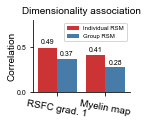

In [14]:
df_rsm_group = {}
df_rsm_group['Correlation'] = []
df_rsm_group['Type'] = []
df_rsm_group['Map'] = []

df_rsm_group['Correlation'].append(stats.pearsonr(avg_dim,parcellated_gradients[:,0])[0])
df_rsm_group['Type'].append('Individual RSM')
df_rsm_group['Map'].append('RSFC grad. 1')
#
df_rsm_group['Correlation'].append(stats.pearsonr(avg_dim_groupavg,parcellated_gradients[:,0])[0])
df_rsm_group['Type'].append('Group RSM')
df_rsm_group['Map'].append('RSFC grad. 1')
#
df_rsm_group['Correlation'].append(stats.pearsonr(avg_dim,myelin_map)[0])
df_rsm_group['Type'].append('Individual RSM')
df_rsm_group['Map'].append('Myelin map')
#
df_rsm_group['Correlation'].append(stats.pearsonr(avg_dim_groupavg,myelin_map)[0])
df_rsm_group['Type'].append('Group RSM')
df_rsm_group['Map'].append('Myelin map')
df_rsm_group = pd.DataFrame(df_rsm_group)

fig, ax = plt.subplots(figsize=(2.,1.85))
ax = sns.barplot(x="Map",y="Correlation",hue="Type",data=df_rsm_group,ax=ax,palette="Set1") #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(fontsize=10, rotation=-10);
plt.xlabel(None);
plt.title('Dimensionality association',fontsize=10)
plt.ylabel('Correlation',labelpad=0.2,fontsize=10);
plt.yticks(fontsize=7)
plt.ylim([0,.8])

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h+.15*h)
    text = f'{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center',fontsize=7)
    
plt.legend(prop={'size':6})
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'GroupXSubj_DimensionalityHierarchy.pdf')

#### Compute CI of correlation differences

In [15]:
tmpdf = df_rsm_group.loc[df_rsm_group.Map=='Myelin map']
se = np.sqrt((1/(360-3)+1/(360-3)))
z = (np.arctanh(tmpdf.Correlation.values[1]) - np.arctanh(tmpdf.Correlation.values[0]))/se
p = stats.norm.sf(abs(z))

print('z =', z, '| p =', p)


z = -1.9545702601197863 | p = 0.025316907209526767


# Evaluate if dimensionality compression-then-expansion can be observed with group dimensionality maps

Sensory vs. Association: t = 1.3992333919613462 | p = 0.16271460083231276 | df = 319
Motor vs. Association: t = 4.092838307203707 | p = 5.5635777641507e-05 | df = 283


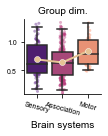

In [19]:
df_system = {}
df_system['Dimensionality'] = []
df_system['System'] = []
df_system['Parcel'] = []

for net in sensorynets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim_groupavg[roi])
        df_system['System'].append('Sensory')
        df_system['Parcel'].append(roi)

for net in associationnets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim_groupavg[roi])
        df_system['System'].append('Association')
        df_system['Parcel'].append(roi)
        
for net in motornets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim_groupavg[roi])
        df_system['System'].append('Motor')
        df_system['Parcel'].append(roi)


                           
        
df_system = pd.DataFrame(df_system)


plt.figure(figsize=(1.6,2))
ax = sns.boxplot(x="System",y="Dimensionality",sym='',whis=[2.5,97.5],data=df_system,palette='magma') #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="System",y="Dimensionality",alpha=0.4,s=3,data=df_system,palette='magma',zorder=0)
tmp = df_system.groupby('System',sort=False).mean()
y = tmp.Dimensionality.values
sns.lineplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
sns.scatterplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
plt.xticks(fontsize=10);
plt.xlabel('Brain systems',fontsize=10);
plt.ylabel(None)
plt.title('Group dim.', fontsize=10);
plt.xticks(fontsize=7,rotation=-15)
plt.yticks(fontsize=7)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'GROUPDimensionalityXBrainSystems.pdf',transparent=True)

# Statistical testing
df_assoc = df_system.loc[df_system.System=='Association']
df_sensory = df_system.loc[df_system.System=='Sensory']
df_motor = df_system.loc[df_system.System=='Motor']

t, p = stats.ttest_ind(df_sensory.Dimensionality.values,df_assoc.Dimensionality.values)
print('Sensory vs. Association: t =', t, '| p =', p, '| df =', len(df_sensory.Dimensionality.values) + len(df_assoc.Dimensionality.values)-2)
t, p = stats.ttest_ind(df_motor.Dimensionality.values,df_assoc.Dimensionality.values)
print('Motor vs. Association: t =', t, '| p =', p, '| df =', len(df_motor.Dimensionality.values) + len(df_assoc.Dimensionality.values)-2)


# Surface plots of Group Dimensionality

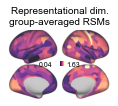

In [21]:
vrange=2

if not os.path.exists(figuredir + 'GroupLevelSurfaceDimensionality.png'):
    tmp = np.hstack((avg_dim_groupavg[180:],avg_dim_groupavg[:180]))
    tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'GroupLevelSurfaceDimensionality.png',tmp,cmap='magma')

fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'GroupLevelSurfaceDimensionality.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Representational dim.\ngroup-averaged RSMs',fontsize=10)
vmin, vmax = np.min(avg_dim_groupavg), np.max(avg_dim_groupavg)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'GroupLevelSurfaceDimensionality_cmap.png',dpi=300,transparent=True)